In [1]:
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch 
import torch.nn as nn 
from torch.utils.tensorboard import SummaryWriter
from data.utils import ImageNormalization
from models.module import ConvModule
import configs.tiny_segmentation as config
import matplotlib.pyplot as plt 
from torchsummary import summary
import cv2
import numpy as np 
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from torch.utils.data import DataLoader
from PIL import ImageOps


In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    ImageNormalization(),
    transforms.Resize((config.image_height, config.image_width))
])


mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((config.mask_height, config.mask_width)),
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    ImageNormalization(),
    transforms.Resize((config.image_height, config.image_width)),
    
])

In [3]:
VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, year="2007", mask_transform=None, transform=None):
        self.mask_transform = mask_transform
        super().__init__(root=root, image_set=image_set, download=download, year=year, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            # makes sense, check for color code basically, set to zero else
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        # apply transforms 
        if self.transform is not None: 
            image = self.transform(image)
        # resize masks 
        if self.mask_transform is not None: 
            mask = self.mask_transform(mask)

        return image, mask


In [4]:
train_dataset =  PascalVOCDataset(root="../../research/dataset/", download=False, year="2012", image_set="train", mask_transform=mask_transform, transform=train_transform)
val_dataset = PascalVOCDataset(root="../../research/dataset/", download=False, year="2012", image_set="val", mask_transform=mask_transform, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, num_workers=4, shuffle=True)


torch.Size([2, 3, 488, 488])
torch.Size([2, 21, 292, 292])
tensor(0.) tensor(0.0039)


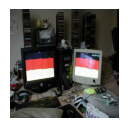

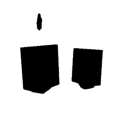

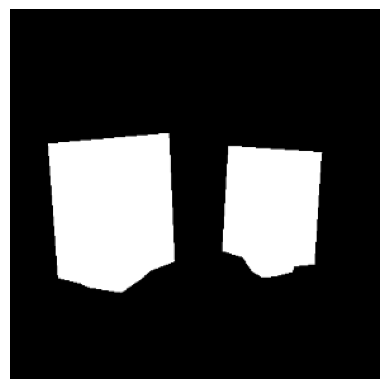

In [5]:
### check data 

for data in train_loader: 
    imgs, masks = data

    print(imgs.shape)
    print(masks.shape)
    print(imgs.min(), imgs.max())

    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        np_img = torch.permute(imgs[i] * 255.0, (1, 2, 0)).numpy()
        plt.imshow(np_img)
        plt.axis("off")
    
    plt.show()
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        np_img = torch.permute(masks[i], (1, 2, 0)).numpy()
        
        for idx, label  in enumerate(VOC_COLORMAP):  
            if np.max(np_img[:, :,idx]) == 1.0: 
                plt.imshow(np_img[:, :, idx], cmap="gray")
                plt.axis("off")
                plt.show()
    

    break


In [6]:
class UnetBlock(nn.Module): 

    def __init__(
        self, 
        in_c, 
        out_c, 
        kernel_size=3,
        stride=1, 
        padding=0
    ): 
        super().__init__()
        self.conv1 = ConvModule(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = ConvModule(out_c, out_c, kernel_size, stride, padding)

    def forward(self, x): 
        out = self.conv1(x) 
        out = self.conv2(out)
        return out 


class ExpansiveBlock(nn.Module):

    def __init__(
        self, 
        in_c, 
        out_c, 
        kernel_size=3,
        stride=1, 
        padding=0
    ): 
        super().__init__()
        self.conv1 = ConvModule(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = ConvModule(out_c, out_c, kernel_size, stride, padding)
        self.upsampling = nn.ConvTranspose2d(out_c, out_c//2, 2, 2, 0)


    def forward(self, x): 
        out = self.conv1(x) 
        out = self.conv2(out)
        out = self.upsampling(out)
        return out



In [7]:
class Unet(nn.Module): 
    
    def __init__(self, num_classes): 
        super().__init__()

        self.num_classes = num_classes
        
        self.conv1 = UnetBlock(3, 64, 3, 1)
        self.conv2 = UnetBlock(64, 128, 3, 1)
        self.conv3 = UnetBlock(128, 256, 3, 1)
        self.conv4 = UnetBlock(256, 512, 3, 1)
        self.conv5 = nn.Sequential(
            ConvModule(512, 1024, 3, 1),
            ConvModule(1024, 1024, 3, 1), 
            nn.ConvTranspose2d(1024, 512, 2, 2, 0), 
            nn.ReLU()
        )

        self.max_pool1 = nn.MaxPool2d(2, 2)

        self.upconv1 = ExpansiveBlock(1024, 512, 3, 1)
        self.upconv2 = ExpansiveBlock(512, 256, 3, 1)
        self.upconv3 = ExpansiveBlock(256, 128, 3, 1)

        self.conv3x3_1 = nn.Conv2d(128, 64, 3, 1, 0)
        self.relu_1 = nn.ReLU()
        self.conv3x3_2 = nn.Conv2d(64, 64, 3, 1, 0)
        self.relu_2 = nn.ReLU()
        self.conv1x1 = nn.Conv2d(64, num_classes, 1, 1, 0)

    def forward(self, x): 

        out1 = self.conv1(x) 
        out1_pool = self.max_pool1(out1)
        out2 = self.conv2(out1_pool) 
        out2_pool = self.max_pool1(out2)
        out3 = self.conv3(out2_pool) 
        out3_pool = self.max_pool1(out3)
        out4 = self.conv4(out3_pool)
        out4_pool = self.max_pool1(out4)
        out5 = self.conv5(out4_pool)
        
        out6 = self.upconv1(torch.concat([transforms.functional.center_crop(out4,(out5.shape[2], out5.shape[3])), out5], dim=1))
        out7 = self.upconv2(torch.concat([transforms.functional.center_crop(out3,(out6.shape[2], out6.shape[3])), out6], dim=1))
        out8 = self.upconv3(torch.concat([transforms.functional.center_crop(out2,(out7.shape[2], out7.shape[3])), out7], dim=1))
        out9 = self.relu_1(self.conv3x3_1(torch.concat([transforms.functional.center_crop(out1,(out8.shape[2], out8.shape[3])), out8], dim=1)))
        out = self.relu_2(self.conv3x3_2(out9))
        out = self.conv1x1(out)

        # if not self.training: 

        # with torch.no_grad(): 
        #     out6_np = torch.permute(out6[0], (1,2,0)).cpu().numpy()
        #     out7_np = torch.permute(out7[0], (1,2,0)).cpu().numpy()
        #     out8_np = torch.permute(out8[0], (1,2,0)).cpu().numpy()
        #     out9_np = torch.permute(out9[0], (1,2,0)).cpu().numpy()


        #     out7_input = torch.permute(
        #         torch.concat([transforms.functional.center_crop(out2,(out6.shape[2], out6.shape[3]))], dim=1)[0]
        #         ,(1,2,0)).cpu().numpy()
        #     out8_input = torch.permute(
        #         torch.concat([transforms.functional.center_crop(out1,(out7.shape[2], out7.shape[3]))], dim=1)[0]
        #         ,(1,2,0)).cpu().numpy()


        #     plt.imshow(out6_np[:, :, 0])
        #     plt.title("Out 6")
        #     plt.show()


        #     plt.imshow(out7_input[:, :, 0])
        #     plt.title("out 7 input")
        #     plt.show()

        #     plt.imshow(out8_input[:, :, 0])
        #     plt.title("out 7 input")
            # plt.show()

            # plt.imshow(out7_np[:, :, 0])
            # plt.title("Out 7")
            # plt.show()

            # plt.imshow(out8_np[:, :, 0])
            # plt.title("Out 8")
            # plt.show()

            # plt.imshow(out9_np[:, :, 0])
            # plt.title("Out 9")
            # plt.show()

        return out



In [8]:

import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64))
        self.down2 = (Down(64, 128))
        self.down3 = (Down(128, 256))
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor))
        self.up1 = (Up(512, 256 // factor, bilinear))
        self.up2 = (Up(256, 128 // factor, bilinear))
        self.up3 = (Up(128, 64 // factor, bilinear))
        self.up4 = (Up(64, 32, bilinear))
        self.outc = (OutConv(32, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)


In [9]:
summary(Unet(len(VOC_COLORMAP)), (3, 488, 488), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
├─UnetBlock: 1-1                         [-1, 64, 484, 484]        --
|    └─ConvModule: 2-1                   [-1, 64, 486, 486]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 486, 486]        1,728
|    |    └─BatchNorm2d: 3-2             [-1, 64, 486, 486]        128
|    |    └─ReLU: 3-3                    [-1, 64, 486, 486]        --
|    └─ConvModule: 2-2                   [-1, 64, 484, 484]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 484, 484]        36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 484, 484]        128
|    |    └─ReLU: 3-6                    [-1, 64, 484, 484]        --
├─MaxPool2d: 1-2                         [-1, 64, 242, 242]        --
├─UnetBlock: 1-3                         [-1, 128, 238, 238]       --
|    └─ConvModule: 2-3                   [-1, 128, 240, 240]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 240, 240]       73,728
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─UnetBlock: 1-1                         [-1, 64, 484, 484]        --
|    └─ConvModule: 2-1                   [-1, 64, 486, 486]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 486, 486]        1,728
|    |    └─BatchNorm2d: 3-2             [-1, 64, 486, 486]        128
|    |    └─ReLU: 3-3                    [-1, 64, 486, 486]        --
|    └─ConvModule: 2-2                   [-1, 64, 484, 484]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 484, 484]        36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 484, 484]        128
|    |    └─ReLU: 3-6                    [-1, 64, 484, 484]        --
├─MaxPool2d: 1-2                         [-1, 64, 242, 242]        --
├─UnetBlock: 1-3                         [-1, 128, 238, 238]       --
|    └─ConvModule: 2-3                   [-1, 128, 240, 240]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 240, 240]       73,728
| 

In [10]:
def process_predictions(predictions): 

    # predictions : (n, 21, H, W)
    softmax_preds = torch.nn.functional.softmax(predictions, dim=1)
    mask = torch.argmax(softmax_preds, axis=1)
    # max_values = torch.max(softmax_preds, axis=1, keepdim=True)[0]
    # outputs = torch.where(softmax_preds == max_values, 1, 0)
    return mask            
            
             

def train(model, optimizer, criterion, train_loader, epoch, writer=None, scheduler=None): 

    if not writer: 
        print("No writer selected, tensorboard will not be used")
    
    # if not scheduler: 
    #     print("No learning rate scheduler") 

    
    total_loss = 0.0
    for i, data in enumerate(train_loader): 
        imgs, masks = data 
        # fix use of global variable 
        imgs = imgs.to(config.device)
        masks = masks.to(config.device)
        model.zero_grad()

        predictions = model(imgs) 


        loss = criterion(predictions, masks)   
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step() 


    with torch.no_grad():

        softmax_preds = torch.nn.functional.softmax(predictions[0], dim=0) 

        for idx in range(softmax_preds.shape[0]): 
            if torch.max(masks[0, idx, :, :]) == 1: 

                writer.add_image("input", imgs[0] * 255.0, epoch*len(train_loader) + i + 1 + idx)
                writer.add_image("mask", masks[0, idx, :, :][None, :, :], epoch*len(train_loader) + i + 1 + idx)
                writer.add_image("output", softmax_preds[idx, :, :][None, :, :], epoch*len(train_loader) + i + 1 + idx)
            

        grad_sum = 0.0
        for name, p in model.named_parameters(): 
            norm = p.grad.data.norm(2)
            grad_sum += norm.item() ** 2

        grad_sum = grad_sum ** (1. / 2)
        if writer:
            writer.add_scalar("Train/loss", total_loss / len(train_loader), epoch) 
            writer.add_scalar("Train/gradient_norm", grad_sum, epoch)

        

        print(f"TRAIN epoch = {epoch} |  : loss = {total_loss / len(train_loader)} ")
        total_loss = 0.0


    # if scheduler is not None: 
    #     scheduler.step()




def test(model, criterion, scheduler, val_loader, epoch, writer=None): 

    validation_loss = 0.0 
    lenght = len(val_loader)

    for i, data in enumerate(val_loader):

        imgs, masks = data 
        imgs = imgs.to(config.device)
        masks = masks.to(config.device)

        predictions = model(imgs) 
        loss = criterion(predictions, masks)   
        validation_loss += loss.item()         
    
    
    if writer is not None: 
        writer.add_scalar("Test/loss", validation_loss / lenght, epoch)
        if scheduler is not None: 
            writer.add_scalar("Train/Learning rate", scheduler.get_last_lr()[0], epoch)
            print("Last learning rate : ", scheduler.get_last_lr()[0])
        else: 
            writer.add_scalar("Train/Learning rate", config.lr, epoch)

    print(f"Validation at EPOCH={epoch} : ", validation_loss / lenght)
    


In [11]:
def training_loop(model, optimizer, criterion, train_loader, val_loader, writer=None, scheduler=None):
    
    print("--- Training ---")
    
    for epoch in range(config.epochs): 
        model.train()
        train(model, optimizer, criterion, train_loader, epoch, writer, scheduler)
        model.eval()
        test(model, criterion, scheduler, val_loader, epoch, writer)
    print("--- Training : DONE ---")


In [12]:
def get_model(): 
    model = Unet(len(VOC_COLORMAP))
    model = model.to(config.device)
    print("device : ", next(model.parameters()).device)
    return model 

def get_optimizer(model): 
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=config.lr
    )
    return optimizer 

def get_scheduler(optimizer): 
    scheduler = None
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1)
    return scheduler

def get_criterion():
    loss_weight = torch.ones((len(VOC_COLORMAP)))
    loss_weight[0] = 0.4
    print(loss_weight)
    criterion = nn.CrossEntropyLoss()
    return criterion 

In [13]:
def main(): 

    print("--- Loading model ---")
    model = get_model()
    print("--- Loading model : DONE ---") 

    print("--- Loading optimizer ---")
    optimizer = get_optimizer(model)
    print("--- Loading optimizer : DONE ---")

    print("--- Loading scheduler ---")
    scheduler = get_scheduler(optimizer)
    print("--- Loading scheduler : DONE ---")

    print("--- Loading criterion ---")
    criterion = get_criterion() 
    print("--- Load criterion : DONE ---")

    config_name = f"{type(model).__name__}_\
        lr={config.lr}_\
        bs={config.batch_size}\
        optimizer={type(optimizer).__name__}\
        scheduler={'none' if scheduler is None else type(scheduler).__name__}\
        momentum={config.momentum}\
        voc\
        weight_decay={config.weight_decay}\
        valentin\
        no_weight\
    "
    writer = SummaryWriter("runs/" + config_name)

    # train 
    training_loop(model, optimizer, criterion, train_loader, val_loader, writer, scheduler=None)


In [14]:
len(train_loader)

732

In [15]:
main()

--- Loading model ---
device :  cuda:0
--- Loading model : DONE ---
--- Loading optimizer ---
--- Loading optimizer : DONE ---
--- Loading scheduler ---
--- Loading scheduler : DONE ---
--- Loading criterion ---
tensor([0.4000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])
--- Load criterion : DONE ---
--- Training ---
TRAIN epoch = 0 |  : loss = 1.3206420581930323 
Validation at EPOCH=0 :  1.261943680500162
TRAIN epoch = 1 |  : loss = 1.2849551089962974 
Validation at EPOCH=1 :  1.277320460245527
TRAIN epoch = 2 |  : loss = 1.2693102577589248 
Validation at EPOCH=2 :  1.283737526104368
TRAIN epoch = 3 |  : loss = 1.2675500649734925 
Validation at EPOCH=3 :  1.2523886402105462
TRAIN epoch = 4 |  : loss = 1.2559747120640317 
Validation at EPOCH=4 :  1.2458908947582903
TRAIN epoch = 5 |  : loss = 1.248771304274843 
Validation at EPOCH=5 :  1.2696260864570224
